In [1]:
import sys 
sys.path.append('../scripts/')
from dynamic_programming import *

In [2]:
class BeliefDynamicProgramming(DynamicProgramming): 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, camera, puddle_coef=100.0, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]):
        super().__init__(widths, goal, puddles, time_interval, sampling_num, puddle_coef, lowerleft, upperright)

        self.actions = [(0.0, 2.0), (0.0, -2.0), (1.0, 0.0), (-1.0, 0.0)]
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        
        self.index_nums = np.array([*self.index_nums, len(dev_borders) + 1])
        nx, ny, nt, nh = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt), range(nh)))

        self.value_function, self.final_state_flags =  self.init_belief_value_function()
        self.policy = np.zeros(np.r_[self.index_nums,2]) 
        
        self.dev_borders = dev_borders
        self.dev_borders_side = [dev_borders[0]/10, *dev_borders, dev_borders[-1]*10]
        self.entropy_state_transition_probs = self.init_entropy_transition_probs()
        self.obs_state_transitions = self.init_observation_probs(camera) 

        
    def init_observation_probs(self, camera):
        probs = {}
        nx, ny, nt, _ = self.index_nums
        pos_indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        for index in pos_indexes: 
            pose = self.pose_min + self.widths*(np.array(index).T + 0.5) #セルの中心の座標
            for i in range(len(self.dev_borders_side)-1):
                sigma = (self.dev_borders_side[i] + self.dev_borders_side[i+1])/2
                S = np.diag([sigma**2, sigma**2, sigma**2]) #sigmaから計算される姿勢の共分散行列
            
                for d in camera.data(pose): #センサ値を繰り返しSに適用
                    S = self.observation_update(d, S, camera, pose)
            
                sigma_after = self.cov_to_sigma(S)
                index_after = self.sigma_to_index(sigma_after)
                probs[(index, i)] = {index_after:1.0}

        return probs
    
    def observation_update(self, d, S, camera, pose):
        distance_dev_rate, direction_dev = 0.14, 0.05 #kf.ipynbから持ってくる
        z = d[0]
        obs_id = d[1]
        
        ###Hの計算###
        mx, my = camera.map.landmarks[obs_id].pos
        mux, muy, mut = pose
        q = (mux - mx)**2 + (muy - my)**2
        sqrtq = np.sqrt(q)
        H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])

        ###Qの計算###
        hmu = IdealCamera.observation_function(pose, camera.map.landmarks[obs_id].pos)
        distance_dev = distance_dev_rate*hmu[0]
        Q = np.diag(np.array([distance_dev**2, direction_dev**2]))
        K = S.dot(H.T).dot(np.linalg.inv(Q + H.dot(S).dot(H.T)))
        return (np.eye(3) - K.dot(H)).dot(S)
        
    def init_entropy_transition_probs(self):
        tmp = {}
        for a in self.actions:
            for i in range(len(self.dev_borders)+1):
                probs = self.entropy_transition_probs(100, self.dev_borders_side[i], self.dev_borders_side[i+1], a)
                tmp[(i, a)] = probs
                
        return tmp
            
    def sigma_to_index(self, sigma):
        for i, e in enumerate(self.dev_borders):
            if sigma < e: return i
            
        return len(self.dev_borders)
    
    def cov_to_sigma(self, cov):
            h = 1.5*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov)) + 1.5
            return np.power(np.e, h/3 - 0.5*np.log(2*np.pi) - 0.5)
        
    def entropy_transition_probs(self, sampling_num, min_sigma, max_sigma, action):
        nu, omega = action
        if abs(omega) < 1e-5: omega = 1e-5
            
        F = np.diag([1.0, 1.0, 1.0])
        F[0, 2] = nu / omega * (math.cos(omega * self.time_interval) - 1.0)#ロボットの向きは関係ないので0[deg]で固定で
        F[1, 2] = nu / omega * (math.sin(omega * self.time_interval))
        
        v ={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2} #移動の誤差モデル（カルマンフィルタのものをコピペ）
        M = np.diag([v["nn"]**2*abs(nu)/self.time_interval + v["no"]**2*abs(omega)/self.time_interval, 
                         v["on"]**2*abs(nu)/self.time_interval + v["oo"]**2*abs(omega)/self.time_interval])

        stw, ctw = math.sin(omega*self.time_interval), math.cos(omega*self.time_interval)
        A = np.array([[stw/omega,    -nu/(omega**2)*stw + nu/omega*self.time_interval*ctw],
                                     [(-ctw + 1.0)/omega, -nu/(omega**2)*(-ctw + 1.0) + nu/omega*self.time_interval*stw],
                                     [0,                                self.time_interval]] )
        
        ans = {}
        for sigma in np.linspace(min_sigma, max_sigma*0.999, sampling_num):
            sigma_after = self.cov_to_sigma(sigma*sigma*F.dot(F.T) + A.dot(M).dot(A.T))
            index_after = self.sigma_to_index(sigma_after)
            
            if index_after not in ans:
                ans[index_after] = 0

            ans[index_after] += 1
                
        for e in ans:
            ans[e] /= sampling_num

        return ans
    
    def init_belief_value_function(self): 
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.belief_final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def belief_final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index[0:3] 
        x_max, y_max, _ = self.pose_min + self.widths*(index[0:3] + 1) 
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] 
        return all([self.goal.inside(np.array(c).T) for c in corners ]) and index[3] == 0
    
    def action_value(self, action, index, out_penalty=True):###beliefdp6
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:
            after, out_reward = self.out_correction(np.array(index[0:3]).T + delta)
        
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            for h_after, h_prob in self.entropy_state_transition_probs[(index[3], action)].items():
                for h_obs, h_obs_prob in dp.obs_state_transitions[(tuple(after), h_after)].items():
              #      large_cov_reward = -1.0 if h_obs >= 3 else 0.0
                    value += (self.value_function[tuple([*after, h_obs])] + reward) * prob * h_prob * h_obs_prob  #さらにh_obs_probをかける

        return value

In [3]:
puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)]

##地図とカメラを作る##
m = Map()
for ln in [(1,4), (4,1), (-4, 1), (-2, 1)]: m.append_landmark(Landmark(*ln))
c = IdealCamera(m)
    
dp = BeliefDynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10, c) #カメラを加える

In [4]:
def save():
    with open("policy_amdp.txt", "w") as f:  ###dp2writepolicy
        for index in dp.indexes:
            p = dp.policy[index]
            f.write("{} {} {} {} {} {}\n".format(index[0], index[1], index[2],index[3], p[0], p[1]))

    with open("value_amdp.txt", "w") as f:
        for index in dp.indexes:
            p = dp.value_function[index]
            f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], index[3], p))

delta = 1e100
counter = 0

while delta > 0.01: 
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)
    save()

1 99.89247284552096
2 98.16110533973782
3 53.190112322917635
4 41.88416595891444
5 29.19848473508501
6 20.905995799009794
7 18.884000922734586
8 16.72135153222328
9 15.34298677037328
10 14.572630504070816
11 13.68595939179982
12 12.602513004297649
13 11.39944359469309
14 9.804150511373141
15 9.125914876629807
16 8.696968032146472
17 8.321241348157791
18 8.123523930027709
19 7.783658338206806
20 7.367868399960031
21 7.116006436396958
22 6.8884549816434415
23 6.68312434605059
24 6.495886703928463
25 6.331153096477109
26 6.232152330456614
27 6.07895891335923
28 5.936581075864439
29 5.803776635918865
30 5.683654500732004
31 5.566767163580359
32 5.456880922302567
33 5.353340013488825
34 5.2555726765131965
35 5.163083549679087
36 5.075442100941572
37 4.992268282553887
38 4.913219170330535
39 4.8212816114929495
40 4.664517816135167
41 4.4481798825655545
42 4.1899530175574995
43 3.8909011537204776
44 3.7699361255158905
45 3.602536038583011
46 3.3934867632678234
47 3.1846024490467713
48 3.02137

<IPython.core.display.Javascript object>


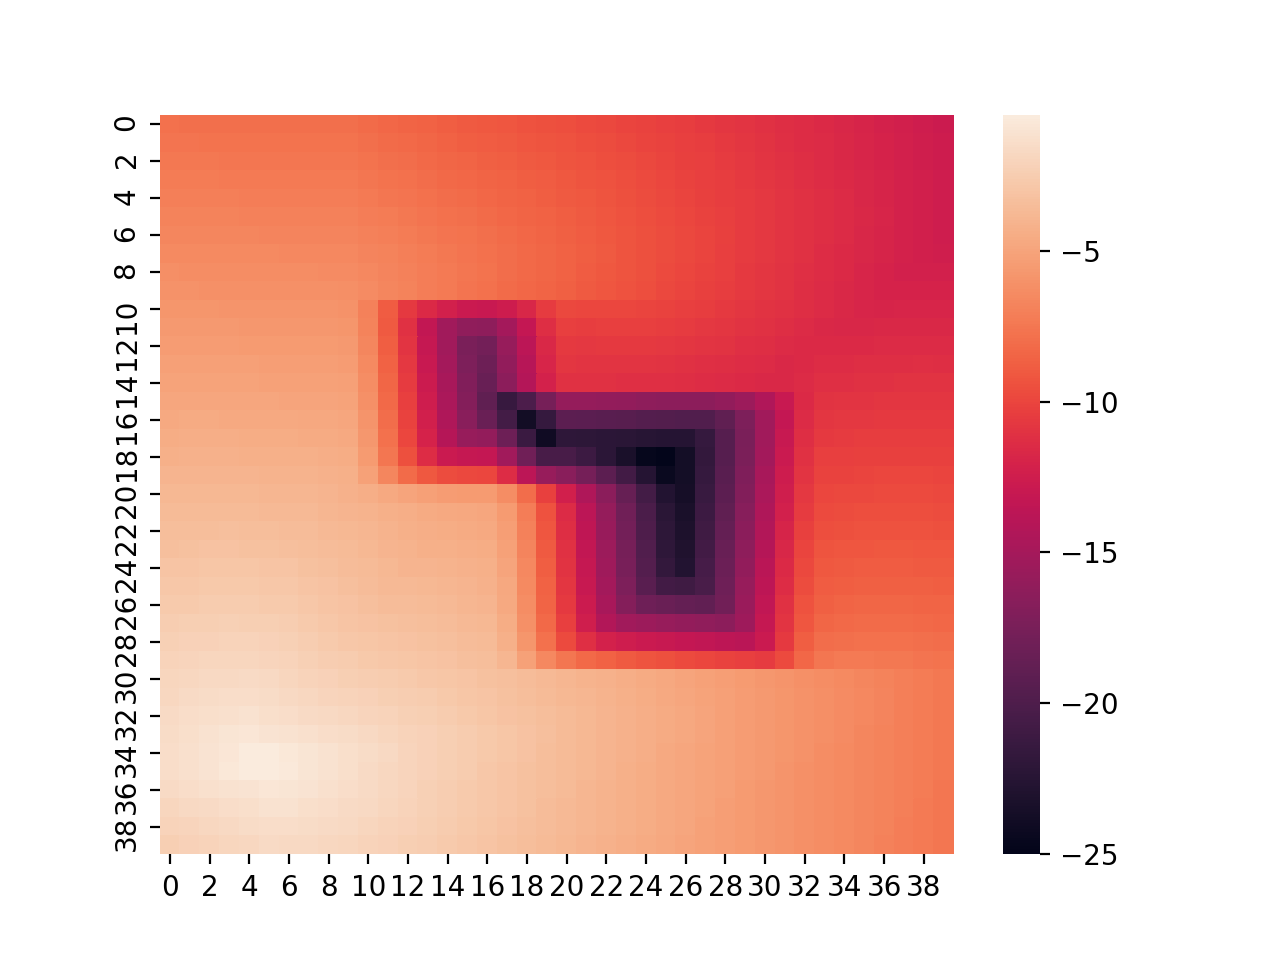

In [5]:
import seaborn as sns
v = dp.value_function[:, :, 18, 4]
sns.heatmap(np.rot90(v), square=False)
plt.show()